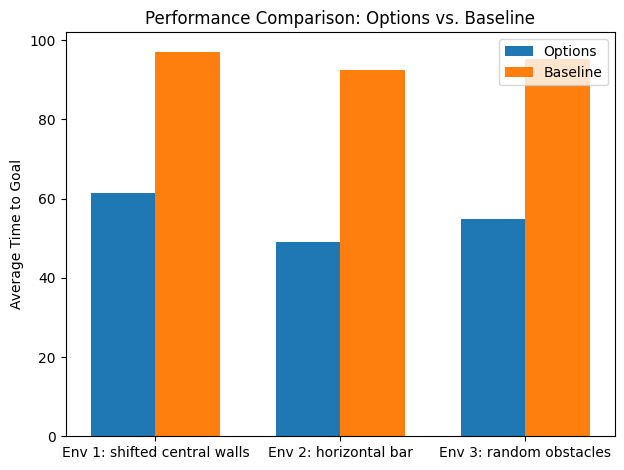

In [14]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig

# 1. Environment Setup (Basic Four-Room - adapted from MiniGrid)
class FourRoomEnv(gym.Env):
    def __init__(self, grid_size=19, walls=None, doors=None, max_steps=100):
        super().__init__()
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.observation_space = Box(low=0, high=255, shape=(grid_size, grid_size, 3), dtype=np.uint8)
        self.action_space = Discrete(4)  # 0: up, 1: right, 2: down, 3: left
        self.current_step = 0

        # Base grid with outer walls
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.grid[0, :] = 1
        self.grid[-1, :] = 1
        self.grid[:, 0] = 1
        self.grid[:, -1] = 1

        # Interior walls (four rooms) if no custom walls
        if walls is None:
            half = grid_size // 2
            self.grid[half, 1:half] = 1
            self.grid[half, half+1:-1] = 1
            self.grid[1:half, half] = 1
            self.grid[half+1:-1, half] = 1
        else:
            # custom walls: list of (row, col)
            for (r, c) in walls:
                self.grid[r, c] = 1

        # Doors (default or custom)
        if doors is None:
            quarter = grid_size // 4
            half = grid_size // 2
            default_doors = [ (half, quarter), (quarter, half), (half, 3*quarter), (3*quarter, half) ]
        else:
            default_doors = doors
        for (r, c) in default_doors:
            self.grid[r, c] = 0

        self.agent_pos = None
        self.goal_pos = None
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        # random start and goal in free cells
        free = list(zip(*np.where(self.grid == 0)))
        self.agent_pos = tuple(self.np_random.choice(free))
        self.goal_pos = tuple(self.np_random.choice([f for f in free if f != self.agent_pos]))
        return self._get_obs(), {}

    def _get_obs(self):
        obs = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8)
        obs[self.agent_pos[0], self.agent_pos[1], 0] = 255
        obs[self.goal_pos[0], self.goal_pos[1], 1] = 255
        obs[:, :, 2] = self.grid * 255
        return obs

    def step(self, action):
        self.current_step += 1
        r, c = self.agent_pos
        if action == 0:
            nr, nc = r-1, c
        elif action == 1:
            nr, nc = r, c+1
        elif action == 2:
            nr, nc = r+1, c
        elif action == 3:
            nr, nc = r, c-1
        else:
            raise ValueError

        if self.grid[nr, nc] == 0:
            self.agent_pos = (nr, nc)
        done = self.agent_pos == self.goal_pos
        truncated = self.current_step >= self.max_steps
        reward = 1 if done else 0
        return self._get_obs(), reward, done, truncated, {}

    def render(self):
        plt.imshow(self._get_obs()); plt.axis('off'); plt.show()

# 2. Agent Space Encoding
def encode_agent_space(state, grid_size):
    """
    Encodes the agent's state into an agent-centric representation.

    Args:
        state: The environment state (e.g., agent_pos, goal_pos, grid).
        grid_size: The size of the grid.

    Returns:
        A tuple representing the agent's encoded state:
        (room_number, normalized_x, normalized_y, door_north, door_east, door_south, door_west)
    """
    agent_pos = state[0]
    grid = state[1]

    # Determine room number (very basic - assumes 4 equally sized rooms)
    room_width = grid_size // 2
    room_height = grid_size // 2
    row, col = agent_pos

    if row < room_height and col < room_width:
        room_number = 0
    elif row < room_height and col >= room_width:
        room_number = 1
    elif row >= room_height and col < room_width:
        room_number = 2
    else:
        room_number = 3

    # Normalize x, y coordinates within the room
    normalized_x = (col % room_width) / (room_width - 1) if room_width > 1 else 0
    normalized_y = (row % room_height) / (room_height - 1) if room_height > 1 else 0

    # Check for doors in the neighborhood
    door_north = 1 if grid[row - 1, col] == 0 and row > 0 else 0
    door_east = 1 if grid[row, col + 1] == 0 and col < grid_size - 1 else 0
    door_south = 1 if grid[row + 1, col] == 0 and row < grid_size - 1 else 0
    door_west = 1 if grid[row, col - 1] == 0 and col > 0 else 0

    return (room_number, normalized_x, normalized_y, door_north, door_east, door_south, door_west)


# 3. Successor Representation Learning (Online)
def learn_sr_online(env, alpha, gamma, num_steps):
    """
    Learns the successor representation online.

    Args:
        env: The environment.
        alpha: The learning rate.
        gamma: The discount factor.
        num_steps: The number of steps to run the learning for.

    Returns:
        A dictionary representing the SR matrix.
    """
    grid_size = env.grid_size
    sr = {}  # Use a dictionary for sparse representation

    obs, _ = env.reset()
    agent_state = env.agent_pos
    grid = env.grid
    state = (agent_state, grid)
    encoded_state = encode_agent_space(state, grid_size)
    last_action = None

    for step in range(num_steps):
        action = env.action_space.sample()  # Explore randomly

        new_obs, reward, terminated, truncated, _ = env.step(action)
        new_agent_state = env.agent_pos
        new_grid = env.grid
        new_state = (new_agent_state, new_grid)

        new_encoded_state = encode_agent_space(new_state, grid_size)


        # Update SR
        if (encoded_state, action) not in sr:
            sr[(encoded_state, action)] = np.zeros(len(encode_agent_space(state,grid_size)), dtype=float)  # Initialize with zeros

        one_hot = np.zeros(len(encode_agent_space(state, grid_size)), dtype=float)
        one_hot[0] = encoded_state[0]
        one_hot[1] = encoded_state[1]
        one_hot[2] = encoded_state[2]
        one_hot[3] = encoded_state[3]
        one_hot[4] = encoded_state[4]
        one_hot[5] = encoded_state[5]
        one_hot[6] = encoded_state[6]


        if (new_encoded_state, action) not in sr:
            sr[(new_encoded_state, action)] = np.zeros(len(encode_agent_space(state,grid_size)), dtype=float)  # Initialize with zeros

        sr[(encoded_state, action)] = sr[(encoded_state, action)] + alpha * (
            one_hot + gamma * np.array(sr[(new_encoded_state, action)]) - np.array(sr[(encoded_state, action)])
        )

        if terminated or truncated:
            obs, _ = env.reset()
            agent_state = env.agent_pos
            grid = env.grid
            state = (agent_state, grid)
            encoded_state = encode_agent_space(state, grid_size)
            last_action = None
        else:
            encoded_state = new_encoded_state

    return sr


# 4. Eigenoption Derivation
def derive_eigenoptions(sr_matrix, num_options, state_dim):
    """
    Derives eigenoptions from the SR matrix.

    Args:
        sr_matrix: The SR matrix (dictionary).
        num_options: The number of eigenoptions to derive.
        state_dim: dimension of the state space
    Returns:
        A list of eigenoptions (eigenvectors).
    """

    # Convert sparse SR matrix to a dense matrix
    #num_states = len(sr_matrix) // 4  # Assuming 4 actions per state #incorrect
    dense_sr = np.zeros((state_dim, state_dim))

    # Fill in the dense matrix
    for (state, action), sr_vector in sr_matrix.items():
      #get the state index
      state_index = state[0] #incorrect
      dense_sr[state_index] = sr_vector

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(dense_sr)

    # Sort eigenvectors by eigenvalues (descending)
    eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]

    # Select the top num_options eigenvectors
    eigenoptions = eigenvectors[:, :num_options]

    return eigenoptions


# 5. Option Q-Learning (Source Environment)
def learn_option_q_learning(env, options, alpha, gamma, epsilon, num_episodes):
    """
    Learns a Q-function over options in the source environment.

    Args:
        env: The environment.
        options: A list of eigenoptions (eigenvectors).
        alpha: The learning rate.
        gamma: The discount factor.
        epsilon: The exploration rate.
        num_episodes: The number of episodes to run the learning for.

    Returns:
        A dictionary representing the Q-function.
    """
    q_table = {}
    num_options = options.shape[1]  # Get the correct number of options

    for episode in range(num_episodes):
        obs, _ = env.reset()
        agent_state = env.agent_pos
        grid = env.grid
        state = (agent_state, grid)
        encoded_state = encode_agent_space(state, env.grid_size)
        terminated = False
        truncated = False

        while not terminated and not truncated:
            # Epsilon-greedy option selection
            if np.random.random() < epsilon:
                option_index = np.random.randint(num_options)  # Explore options randomly
            else:
                # Exploit: Choose the option with the highest Q-value
                option_values = [q_table.get((encoded_state, i), 0) for i in range(num_options)]
                option_index = np.argmax(option_values)

            # Execute the selected option (eigenvector)
            selected_option = options[:, option_index]

            # Take multiple primitive actions based on the eigenvector (option)
            next_state, reward, terminated, truncated = execute_option(env, encoded_state, selected_option)
            next_encoded_state = encode_agent_space((env.agent_pos, env.grid), env.grid_size)  # Encode new state

            # Q-table update
            old_value = q_table.get((encoded_state, option_index), 0)
            next_max = np.max([q_table.get((next_encoded_state, i), 0) for i in range(num_options)])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[(encoded_state, option_index)] = new_value

            encoded_state = next_encoded_state

    return q_table


def execute_option(env, initial_state, option):
    """
    Executes an option (eigenvector) in the environment.

    Args:
        env: The environment.
        initial_state: The initial encoded state.
        option: The option (eigenvector) to execute.

    Returns:
        The next state, reward, terminated, truncated.
    """
    # Map eigenvector values to actions (crude mapping for demonstration)
    actions = np.sign(option[:4])  # Assuming first 4 elements correspond to actions

    obs, _ = env.reset()
    agent_state = env.agent_pos
    grid = env.grid
    state = (agent_state, grid)
    encoded_state = encode_agent_space(state, env.grid_size)
    terminated = False
    truncated = False
    total_reward = 0

    for _ in range(5):  # Execute option for a few steps
        # Choose action based on eigenvector values
        if actions[0] > 0:
            action = 0  # Up
        elif actions[1] > 0:
            action = 1  # Right
        elif actions[2] > 0:
            action = 2  # Down
        else:
            action = 3  # Left

        new_obs, reward, terminated, truncated, _ = env.step(action)
        new_agent_state = env.agent_pos
        new_grid = env.grid
        new_state = (new_agent_state, new_grid)
        encoded_state = encode_agent_space(new_state, env.grid_size)  # Encode new state
        total_reward += reward

        if terminated or truncated:
            break

    return encoded_state, total_reward, terminated, truncated


# 6. Baseline Q-Learning (No Options)
def learn_q_learning_baseline(env, alpha, gamma, epsilon, num_episodes):
    """
    Learns a Q-function using standard Q-learning (no options).

    Args:
        env: The environment.
        alpha: The learning rate.
        gamma: The discount factor.
        epsilon: The exploration rate.
        num_episodes: The number of episodes to run the learning for.

    Returns:
        A dictionary representing the Q-function.
    """
    q_table = {}

    for episode in range(num_episodes):
        obs, _ = env.reset()
        agent_state = env.agent_pos
        grid = env.grid
        state = (agent_state, grid)
        encoded_state = encode_agent_space(state, env.grid_size)
        terminated = False
        truncated = False

        while not terminated and not truncated:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Explore actions randomly
            else:
                # Exploit: Choose the action with the highest Q-value
                action_values = [q_table.get((encoded_state, a), 0) for a in range(env.action_space.n)]
                action = np.argmax(action_values)

            # Take the selected action
            new_obs, reward, terminated, truncated, _ = env.step(action)
            new_agent_state = env.agent_pos
            new_grid = env.grid
            new_state = (new_agent_state, new_grid)
            new_encoded_state = encode_agent_space(new_state, env.grid_size)  # Encode new state

            # Q-table update
            old_value = q_table.get((encoded_state, action), 0)
            next_max = np.max([q_table.get((new_encoded_state, a), 0) for a in range(env.action_space.n)])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[(encoded_state, action)] = new_value

            encoded_state = new_encoded_state

    return q_table


# 7. Evaluate Policy (with and without options)
def evaluate_policy(env, q_table, options=None, num_trials=100, max_steps=100):
    """
    Evaluates the performance of a Q-learning policy (with or without options).

    Args:
        env: The environment.
        q_table: The Q-function.
        options: The eigenoptions (if using options).
        num_trials: The number of trials to run.
        max_steps: The maximum number of steps per trial.

    Returns:
        A list of the time taken to reach the goal for each trial.
    """
    times_to_goal = []

    for trial in range(num_trials):
        obs, _ = env.reset()
        agent_state = env.agent_pos
        grid = env.grid
        state = (agent_state, grid)
        encoded_state = encode_agent_space(state, env.grid_size)
        terminated = False
        truncated = False
        steps = 0

        while not terminated and not truncated and steps < max_steps:
            steps += 1

            if options is not None:
                # Option-based policy
                num_options = options.shape[1]
                option_values = [q_table.get((encoded_state, i), -np.inf) for i in range(num_options)]
                best_option_index = np.argmax(option_values)
                selected_option = options[:, best_option_index]
                encoded_state, reward, terminated, truncated = execute_option(env, encoded_state, selected_option)
                new_agent_state = env.agent_pos
                new_grid = env.grid
                new_state = (new_agent_state, new_grid)
                encoded_state = encode_agent_space(new_state, env.grid_size)  # Encode new state
            else:
                # Standard Q-learning policy
                action_values = [q_table.get((encoded_state, a), -np.inf) for a in range(env.action_space.n)]
                action = np.argmax(action_values)
                new_obs, reward, terminated, truncated, _ = env.step(action)
                new_agent_state = env.agent_pos
                new_grid = env.grid
                new_state = (new_agent_state, new_grid)
                encoded_state = encode_agent_space(new_state, env.grid_size)  # Encode new state


        if terminated:
            times_to_goal.append(steps)
        else:
            times_to_goal.append(max_steps)  # Indicate failure to reach goal

    return times_to_goal


# 8. Performance Comparison and Visualization
def compare_performance(option_results, baseline_results, env_names):
    """
    Compares the performance of option-based and baseline Q-learning and visualizes the results.

    Args:
        option_results: A list of lists, where each inner list contains the times to goal for the option-based policy in a target environment.
        baseline_results: A list of lists, where each inner list contains the times to goal for the baseline policy in a target environment.
        env_names: A list of names for the target environments.
    """
    num_envs = len(env_names)
    x = np.arange(num_envs)
    width = 0.35

    fig, ax = plt.subplots()
    option_means = [np.mean(results) for results in option_results]
    baseline_means = [np.mean(results) for results in baseline_results]

    rects1 = ax.bar(x - width/2, option_means, width, label='Options')
    rects2 = ax.bar(x + width/2, baseline_means, width, label='Baseline')

    ax.set_ylabel('Average Time to Goal')
    ax.set_title('Performance Comparison: Options vs. Baseline')
    ax.set_xticks(x)
    ax.set_xticklabels(env_names)
    ax.legend()

    fig.tight_layout()
    plt.show()



# --- Main ---
# 1. Create environments
source_env = FourRoomEnv(grid_size=19)
target_configs = [
    { 'name': 'Env 1: shifted central walls',
      'walls': [(grid_r, grid_c) for grid_r in range(1,9) for grid_c in [9]] + \
               [(grid_r, grid_c) for grid_r in [9] for grid_c in range(10,18)] },
    { 'name': 'Env 2: horizontal bar',
      'walls': [(10, c) for c in range(1,18)] },
    { 'name': 'Env 3: random obstacles',
      'walls': [(np.random.randint(1,18), np.random.randint(1,18)) for _ in range(30)] }
]

env_size = 19
source_env = FourRoomEnv(grid_size=env_size)

# Learn SR
sr_matrix = learn_sr_online(source_env, alpha=0.1, gamma=0.9, num_steps=10000)
state_dim = len(encode_agent_space(((0,0), source_env.grid), env_size))
eigenoptions = derive_eigenoptions(sr_matrix, num_options=4, state_dim=state_dim)
option_q_function = learn_option_q_learning(source_env, eigenoptions, alpha=0.1, gamma=0.9, epsilon=0.1, num_episodes=500)

# Evaluate on each target
option_results, baseline_results, env_names = [], [], []
for cfg in target_configs:
    env = FourRoomEnv(grid_size=env_size, walls=cfg['walls'])
    env_names.append(cfg['name'])
    option_results.append(evaluate_policy(env, option_q_function, options=eigenoptions))
    q_baseline = learn_q_learning_baseline(env, alpha=0.1, gamma=0.9, epsilon=0.1, num_episodes=500)
    baseline_results.append(evaluate_policy(env, q_baseline))

# Compare and plot
compare_performance(option_results, baseline_results, env_names)
